# Almgren-Chriss Optimal Execution - Efficient Frontier approach

## Syllabus

1. Almgren-Chriss framework
2. Efficient frontier for implementation shortfall
3. Efficient frontier for VWAP
4. Efficient frontier for TWAP

## 1. Almgren-Chriss framework

The **Almgren-Chriss framework** (1999) is a mathematical model that looks to:

- Estimate the optimal pace to build/unwind a trading position, issues often faced by brokers and traders (but has not seen as much interest from statisticians, economists and econophysicists in the past decades);
- Allows one to graphically represent the trade-off between slow/fast execution;
- Ease to choose one's own prefered approach to model market impact costs;
- Avoids the temptation of modelling the market as a physical system fully enclosed in its own data (*physics envy*);
- Designed from a bottom-top approach: the modelling is based on the execution process itself;
- Provides a multitude of modelling approaches to compute the slow/fast execution trade-off (e.g. KKT nonlinear optimization, dynamic programming, stochastic control, reinforcement learning, etc.).

We will present 2 approaches to solve the Almgren-Chriss model:

- Efficient Frontier (original method by Almgren-Chriss)
- Dynamic Programming

This notebook will focus on the **efficient frontier** approach.

**Assumptions**

- *Trading trajectory*

$$ x_0 = X $$

$$ n_k = x_k - x_{k-1} $$

$$ x_k = X - \sum_{j=1}^k n_j = \sum_{j=k+1}^N n_k, \, \, \, \,\, \, \,\, \, \,   k=0,...,N $$

- *Price trajectory*

$$ S_k = S_{k-1} + \sigma  \sqrt{\tau} \zeta_k - \tau g(\frac{n_k}{\tau}) $$

$$ g(v) = \gamma v $$

$$ S_k = S_0 + \sigma  \sqrt{\tau} \sum_{j=1}^k \zeta_j - \gamma (X - x_k) $$

- *Temporary market impact*

$$ h(v) = \varepsilon sign(n_i) + \frac{\eta}{\tau} n_i $$

$$ \tilde S_k = S_{k-1} - h(\frac{n_k}{\tau}) $$

In [1]:
import numpy as np

# Utilities

def g(x, gamma=1.0):
    """
    Permanent market impact.
    """
    return gamma * x

def h(x, tau=1.0, epsilon=1.0, eta=1.0):
    """
    Temporary market impact.
    """
    return epsilon*np.sign(x) + eta*(x/tau)

## 2. Efficient frontier for implementation shortfall

### 2.1. Optimization

**Moments**

- *IS Algorithm*

$$ X_{IS} = X S_0 - \sum_{i=1}^N n_i \tilde S_i $$

- *Expectation*

$$ \mathbb{E}(X_{IS}) = \sum_{i=1}^N \tau x_i g(\frac{n_i}{\tau}) + \sum_{i=1}^{N} n_i h(\frac{n_i}{\tau}) = \frac{1}{2} \gamma X^2 + \varepsilon \sum_{i=1}^N |n_i| + \frac{\eta-0.5\gamma \tau}{\tau} \sum_{i=1}^N n_i^2 $$

- *Variance*

$$ \mathbb{V}(X_{IS}) = \sigma^2 \sum_{i=1}^N \tau x_i^2 $$

Refresher:

$$ x_t = X - \sum_{j=1}^t n_j = \sum_{j=t+1}^N n_j $$

In [2]:
# Moments

def expectation_IS(N, tau=1.0, gamma=1.0, eta=1.0, eps=1.0):
    """
    Expectation of implementation shortfall.
    """
    exp = 0.5*gamma*X**2 + eps*np.sum(N) + (eta - 0.5*gamma*tau)/tau * np.sum(N**2)
    return exp

def variance_IS(N, sigma=0.3, tau=1.0):
    """
    Variance of implementation shortfall.
    """
    var = 0
    t = - 1
    while t < len(N) - 1:
        t = t + 1
        temp = (X - np.sum(N[0:t])) ** 2
        var = var + temp
    
    var = tau * (sigma**2) * var
    return var

# Objective function

def objective_IS(N):
    """
    Objective function for implementation shortfall.
    """
    obj = expectation_IS(N) + risk * variance_IS(N)
    return obj

**Optimization**:

For determining the optimal liquidation we will use ***sequential quadratic programming*** (SLSQP), an iterative nonlinear optimization method (developped by Kraft D.) through the optimization functions of the `Scipy` library. A nonlinear QP is typically modelled as followed:

$ \min_x \,\, f(x) $

$ s.t. \,\,\,\,\,\,\, g_i(x)<0 \,\,\,\,\,\,\,\,\,\, i=1,...,n_{ineq}$

$ s.t. \,\,\,\,\,\,\, h_i(x)=0 \,\,\,\,\,\,\,\,\,\, i=1,...,n_{eq}$

$f(x)$ is the function to minimize, $g_i(x)$ represents the inequality constraints and $h_i(x)$ represents the equality constraints. By introducing a cost function (or Lagrangian), the nonlinear optimization willy satisfy the *Karush–Kuhn–Tucker* (KKT) conditions thus guarantying that the solution of the QP will be optimal:

$ L(x,\lambda,\nu) = f(x) + \lambda^T g(x) + \nu^T h(x) $

In regards to the specifics of SLSQP, it is similar to Newton's method in that it solves the objective function iteratively through a (quadratic) approximation of the Lagrangian:

$ \min_d \,\, \nabla f(x_k)^T d + \frac{1}{2} d^T H_L(x_k, \lambda_k, \nu_k)d $

$ s.t. \,\,\,\,\,\,\, g_i(x_k) + \nabla g_i(x_k)^T d < 0 $

$ s.t. \,\,\,\,\,\,\, h_j(x_k) + \nabla h_j(x_k)^T d = 0 $

Convergence to the optimal solution is dependent on the Hessian of the Lagrangian $H_L(x_k, \lambda_k, \nu_k)$ and smoothness/convexity of the objective functions. Thus we optimize:

$$ (n_1^*,...,n_N^*) = \min_{0<n_i<X} \mathbb{E}(X_{IS}) + \lambda \mathbb{V}(X_{IS}) $$

In [3]:
# Parameters
nb_T = 50
x0 = np.zeros((nb_T, 1))
X = 40000
risk = 0.05

# Optimization
from scipy.optimize import minimize

bnds = tuple((0.0, X) for x in range(len(x0)))
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - X})

opt = minimize(objective_IS, x0, method='SLSQP', bounds=bnds, constraints=cons)
N_opt = np.array(opt.x)

#print('Liquidation trajectory:\n')
#print(np.matrix(opt.x.round(0)).T)

print('Total number of shares:')
print(np.sum(opt.x))

print('\nExpectation E(x):')
print(expectation_IS(opt.x))

print('\nVariance V(x):')
print(variance_IS(opt.x))

Total number of shares:
40000.0

Expectation E(x):
838002891.072

Variance V(x):
832574043.449


We have the optimal trajectory, now we can detail the liquidation process from the first day till the last:

In [4]:
def liquidation_history(N_opt, X):
    """
    Prints out the liquidation history of the optimal execution.
    """
    hist = np.zeros((len(N_opt), 1))
    hist[0] = X
    
    for i in range(1, len(N_opt)):
        hist[i] = hist[i-1] - N_opt[i]
    
    return hist

hist_opt = liquidation_history(N_opt, X)

#print('Liquidation history:\n')
#print(hist_opt.round(0))

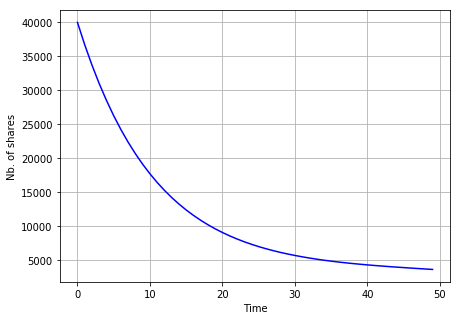

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.plot(hist_opt, color='blue', lw=1.5)
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('Nb. of shares')
plt.show()

We will use this function:

In [6]:
def efficient_frontier_IS(X, risk, nb_T, tau=1.0, gamma=1.0, eta=1.0, eps=1.0, plot='True'):
    
    def expectation_IS(N):
        """
        Expectation of implementation shortfall.
        """
        exp = 0.5*gamma*X**2 + eps*np.sum(N) + (eta - 0.5*gamma)/tau * np.sum(N**2)
        return exp

    def variance_IS(N, sigma=0.3):
        """
        Variance of implementation shortfall.
        """
        var = 0
        t = - 1
        while t < len(N) - 1:
            t = t + 1
            temp = (X - np.sum(N[0:t])) ** 2
            var = var + temp
        var = tau * (sigma**2) * var
        return var
    
    def objective_IS(N):
        """
        Objective function for implementation shortfall.
        """
        obj = expectation_IS(N) + risk * variance_IS(N)
        return obj
    
    def optimization():
        """
        Optimal execution with optimization for implementation shortfall.
        """
        x0 = np.zeros((nb_T, 1))
        bnds = tuple((0.0, X) for x in range(len(x0)))
        cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - X})
        opt = minimize(objective_IS, x0, method='SLSQP', bounds=bnds, constraints=cons)
        N = np.array(opt.x)
        return N
    
    N_opt = optimization()
    
    def liquidation_history(N_opt, X):
        """
        Prints out the liquidation history of the optimal execution.
        """
        hist = np.zeros((len(N_opt), 1))
        hist[0] = X
        for i in range(1, len(N_opt)):
            hist[i] = hist[i-1] - N_opt[i]
        return hist
    
    hist_opt = liquidation_history(N_opt,X)

    def plot_liquidation():
        plt.figure(figsize=(7,5))
        plt.plot(hist_opt, color='blue', lw=1.5)
        plt.grid(True)
        plt.xlabel('Time')
        plt.ylabel('Nb. of shares')
        plt.show()
    
    if plot=='True':
        plot_liquidation()
    
    res = hist_opt.round(0), expectation_IS(N_opt), variance_IS(N_opt)
    
    return res

Risk aversion: 2e-07


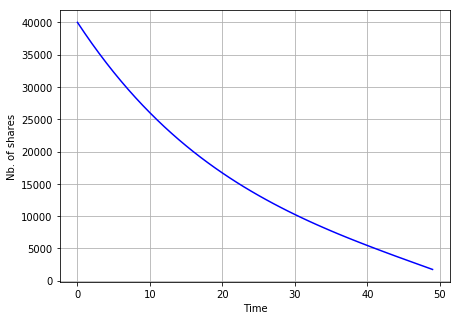

Risk aversion: -2e-07


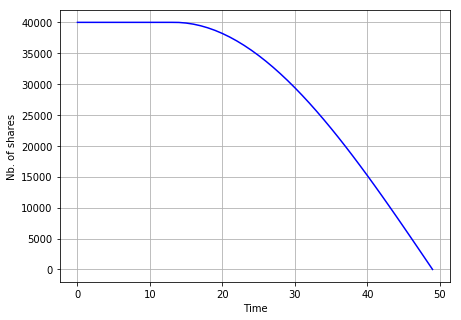

In [7]:
print('Risk aversion:', 2*10**(-7))
test = efficient_frontier_IS(X=40000, risk=2*10**(-7), nb_T=50,
                             tau=0.5,
                             gamma=2.5*10**(-7),
                             eta=2.5*10**(-6),
                             eps=0.0625)

print('Risk aversion:', -2*10**(-7))
test = efficient_frontier_IS(X=40000, risk=-2*10**(-7), nb_T=50,
                             tau=0.5,
                             gamma=2.5*10**(-7),
                             eta=2.5*10**(-6),
                             eps=0.0625)

### 2.2. Efficient frontier

We will test the following parameters:

- $X=40000$
- $N=50$
- $\tau=0.5$
- $\gamma=2.5 \times 10^{-7}$
- $\eta=2.5 \times 10^{-6}$
- $\varepsilon=0.0625$

We should also implement **naive strategies**: selling at a constant rate throughout the entire liquidation (this is known as *minimum impact*).

In [8]:
X = 40000
n = len(hist_opt)
N_naive = np.ones(n) * X / n

x_naive = variance_IS(N_naive, sigma=0.3, tau=0.5)
y_naive = expectation_IS(N_naive, tau=0.5, gamma=2.5*10**(-7), eta=2.5*10**(-6), eps=0.0625)

Now we plot the **efficient frontier** for implementation shortfall:

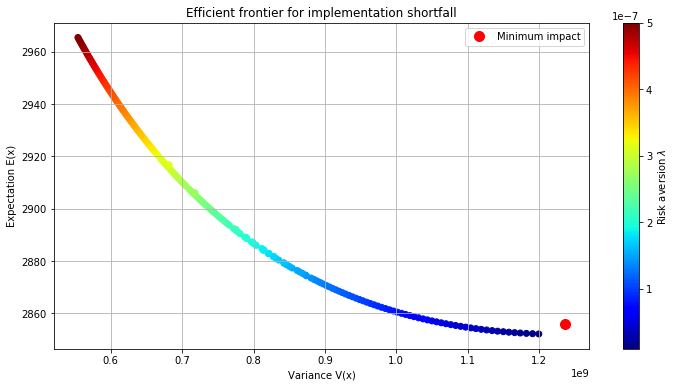

In [47]:
risks = np.linspace(0.1*10**(-7), 5.0*10**(-7), 200)

x_IS = []
y_IS = []

for r in risks:
    temp = efficient_frontier_IS(X=40000, risk=r, nb_T=50,
                                 tau=0.5, gamma=2.5*10**(-7), eta=2.5*10**(-6),
                                 eps=0.0625, plot='False')
    
    x_IS.append(temp[2])  # V(x)
    y_IS.append(temp[1])  # E(x)

# Plotting
plt.figure(figsize=(12,6))

# Optimal strategies
plt.scatter(x_IS, y_IS, marker='o', cmap='jet', c=risks)
plt.plot(x_naive, y_naive, "ro", lw=2, markersize=10, label='Minimum impact', markeredgecolor='red')
plt.grid(True)

plt.xlabel('Variance V(x)')
plt.ylabel('Expectation E(x)')
plt.title('Efficient frontier for implementation shortfall')
plt.colorbar(label='Risk aversion $\lambda$')
plt.legend(loc='best')
plt.savefig('efficient_frontier_IS.png')
plt.show()

For **optimal liquidation trajectories**:

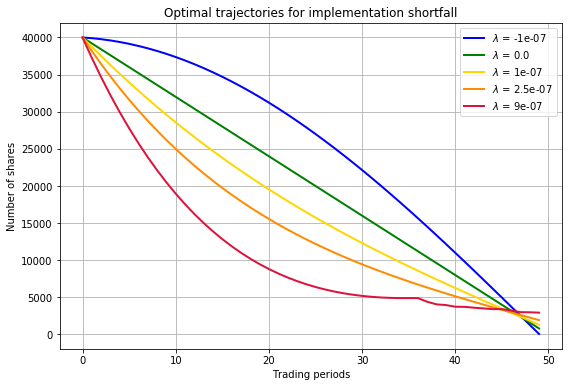

In [12]:
risks = [-1*10**(-7), 0.0, 1.0*10**(-7), 2.5*10**(-7), 9.0*10**(-7)]

N_opts = []

for r in risks:
    temp = efficient_frontier_IS(X=40000, risk=r, nb_T=50,
                                 tau=0.5, gamma=2.5*10**(-7), eta=2.5*10**(-6),
                                 eps=0.0625, plot='False')
    
    N_opts.append(temp[0])


# Plotting
plt.figure(figsize=(9,6))
plt.plot(N_opts[0], color='blue', lw=2.0, label='$\lambda$ = '+str(risks[0]))
plt.plot(N_opts[1], color='green', lw=2.0, label='$\lambda$ = '+str(risks[1]))
plt.plot(N_opts[2], color='gold', lw=2.0, label='$\lambda$ = '+str(risks[2]))
plt.plot(N_opts[3], color='darkorange', lw=2.0, label='$\lambda$ = '+str(risks[3]))
plt.plot(N_opts[4], color='crimson', lw=2.0, label='$\lambda$ = '+str(risks[4]))

plt.grid(True)
plt.title('Optimal trajectories for implementation shortfall')
plt.xlabel('Trading periods')
plt.ylabel('Number of shares')
plt.legend(loc='best')
plt.savefig('liquidation_IS.png')
plt.show()

## 3. Efficient frontier for VWAP

### 3.1. Model

We adapt the Almgren-Chriss framework to the VWAP and TWAP algorithms with the help of O. Guéant's *The Financial Mathematics of Market Liquidity* (2016). VWAP (and TWAP) are popular algorithms among market making participants to follow closely the average price movements. The VWAP in particular is useful as a benchmark for both ensuring that the agent's liquidation decisions are in line with his strategy and low transaction costs.

**Moments**

- *VWAP Algorithm*

$$ X_{VWAP} = X\frac{\sum_{i=1}^n S_i V_i}{\sum_{i=1}^n V_i} - \sum_{i=1}^n n_i \tilde S_i $$

- *Expectation*

$$ \mathbb{E}(X_{VWAP}) = \sum_{i=1}^n \left[\left(\frac{X}{V} V_i - n_i\right) \left (S_0 - \tau \sum_{j=1}^{i-1} g \left(\frac{n_j}{\tau}\right) \right) - \frac{X}{V} V_i \tau g \left(\frac{n_i}{\tau}\right) - n_i h\left(\frac{n_i}{\tau}\right)\right]$$

- *Variance*

$$ \mathbb{V}(X_{VWAP}) = \tau \sigma^2 \sum_{i=1}^n \left(\frac{X}{V} \sum_{j=i}^n V_j - x_i \right)^2 $$

In [13]:
nb_T = 10
X = 40000
V = 100000
v = np.ones((nb_T,1)) * V / nb_T
n0 = np.ones((nb_T,1)) * X / nb_T

def expectation_VWAP(n):
    """
    Returns the expected VWAP
    n, array - Trading trajectory
    X, integer - Number of shares to be liquidated
    s0, float - Initial spot price
    gamma, float - Parameter of the permanent market impact
    tau, float - Trading frequency
    eta, float - Parameter of the temporary market impact
    eps, float - Fixed cost of selling in the temporary market impact
    v, array - Volume traded during the day
    """
    # s0=100, tau=1, gamma=1, eta=1, eps=1
    
    N = len(n)
    e = 0
    V = v.sum()
    # T = tau * N
    for k in range(N):
        gsum = 0
        for j in range(k):
            gsum+=g(n[j]/tau, gamma)
        e+=(X*v[k]/V - n[k])*(s0-gsum*tau) - X/V * tau*v[k]*g(n[k]/tau, gamma) + n[k]*h(n[k]/tau, tau, eps, eta)
    return e

def variance_VWAP(n):
    """
    Returns the VWAP variance
    n, array - Trading trajectory
    X, integer - Number of shares to be liquidated
    s0, float - Initial spot price
    gamma, float - Parameter of the permanent market impact
    tau, float - Trading frequency
    eta, float - Parameter of the temporary market impact
    eps, float - Fixed cost of selling in the temporary market impact
    v, array - Volume traded during the day
    """
    # s0=100, X=1000, sigma=0.3, tau=1, gamma=1, eta=1, eps=1
    
    var = 0
    N = len(n)
    V = v.sum()
    for k in range(N):
        vsum = 0
        for j in range(k,N):
            vsum+=v[j]
        x = X - np.sum(n[0:k])     # x[k]
        var+=(X/V * vsum - x)**2
        # print(vsum*X/V, x)
    var = var*sigma**2*tau
    return var

def objective_VWAP(n):
    """
    Objective function for VWAP.
    """
    obj = expectation_VWAP(n) + risk * variance_VWAP(n)
    return obj

**Optimization**

$$ (n_1^*,...,n_N^*) = \min_{0<n_i<X} \mathbb{E}(X_{VWAP}) + \lambda \mathbb{V}(X_{VWAP}) $$

In [14]:
# Parameters
X = 40000.0                           # Number of shares to liquidate
nb_T = 10                             # Number of trading periods
risk = 2.5*10**(-7)                   # Risk aversion

V = 4000000                           # Total volume
v = np.ones((nb_T,1)) * V / nb_T      # Volume history

tau = 0.5                             # Trading speed
gamma = 2.5*10**(-7)                  # Permanent market impact
eta = 2.5*10**(-6)                    # Temporary (variable) market impact
eps = 0.0625                          # Temporary (fixed) market impact
sigma = 0.3                           # Volatility
s0 = 100
n0 = np.ones((nb_T,1)) * X / nb_T

print(expectation_VWAP(n0))
print(variance_VWAP(n0))
print(objective_VWAP(n0))

[ 4060.]
[ 0.]
[ 4060.]


In [15]:
# Parameters
X = 40000                          # Number of shares to liquidate
nb_T = 50                          # Number of trading periods
risk = 2.5*10**(-7)                # Risk aversion

V = 20000                          # Total volume
v = np.ones((nb_T,1)) * V / nb_T   # Volume history

tau = 0.5                          # Trading speed
gamma = 2.5*10**(-7)               # Permanent market impact
eta = 2.5*10**(-6)                 # Temporary (variable) market impact
eps = 0.0625                       # Temporary (fixed) market impact
sigma = 0.3                        # Volatility

# Optimization
from scipy.optimize import minimize

x0 = np.zeros((nb_T, 1))         # Dimensionality of the optimization

bnds = tuple((0.0, X) for x in range(len(x0)))
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - X})

opt = minimize(objective_VWAP, x0, method='SLSQP', bounds=bnds, constraints=cons,
              options={'maxiter': 10000})
N_opt = np.array(opt.x)
print(opt)

# print('Liquidation trajectory:\n')
# print(np.matrix(opt.x.round(0)).T)

print('\nTotal number of shares:')
print(np.sum(opt.x))

print('\nExpectation E(x):')
print(expectation_VWAP(N_opt))

print('\nVariance V(x):')
print(variance_VWAP(N_opt))

     fun: 2803.8022693430394
     jac: array([-99.91604614, -99.91607666, -99.91607666, -99.91607666,
       -99.91610718, -99.9161377 , -99.9161377 , -99.91616821,
       -99.91619873, -99.91622925, -99.91629028, -99.9163208 ,
       -99.91635132, -99.9125061 , -99.91253662, -99.91650391,
       -99.91262817, -99.91268921, -99.91275024, -99.91281128,
       -99.91674805, -99.91680908, -99.91296387, -99.9130249 ,
       -99.91308594, -99.91314697, -99.91317749, -99.91323853,
       -99.91329956, -99.9133606 , -99.91342163, -99.91348267,
       -99.91351318, -99.91357422, -99.91558838, -99.9156189 ,
       -99.91567993, -99.91571045, -99.91577148, -99.915802  ,
       -99.91583252, -99.91586304, -99.91589355, -99.91494751,
       -99.91497803, -99.91595459, -99.91598511, -99.91549683,
       -99.91577148, -99.91577148])
 message: 'Optimization terminated successfully.'
    nfev: 707
     nit: 13
    njev: 13
  status: 0
 success: True
       x: array([ 998.82689797,  991.17966804,  982.

Liquidation history:


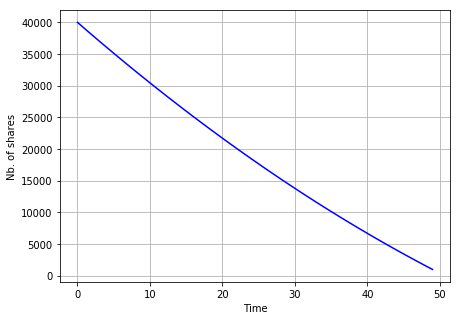

In [16]:
hist_opt = liquidation_history(N_opt, X)

print('Liquidation history:')

plt.figure(figsize=(7,5))
plt.plot(hist_opt, color='blue', lw=1.5)
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('Nb. of shares')
plt.show()

**Hyperparameter testing**:

In [17]:
def efficient_frontier_VWAP(X, risk, nb_T, v, sigma=0.3, s0=100, tau=1.0, gamma=1.0, eta=1.0, eps=1.0, plot='True'):
    
    def expectation_VWAP(n):
        N = len(n)
        e = 0
        V = v.sum()
        # T = tau * N
        for k in range(N):
            gsum = 0
            for j in range(k):
                gsum+=g(n[j]/tau, gamma)
            e+=(X*v[k]/V - n[k])*(s0-gsum*tau) - X/V * tau*v[k]*g(n[k]/tau, gamma) + n[k]*h(n[k]/tau, tau, eps, eta)
        return e
    
    def variance_VWAP(n):
        var = 0
        N = len(n)
        V = v.sum()
        for k in range(N):
            vsum = 0
            for j in range(k,N):
                vsum+=v[j]
            x = X - np.sum(n[0:k])
            var+=(X/V * vsum - x)**2
        var = var*sigma**2*tau
        return var

    def objective_VWAP(n):
        obj = expectation_VWAP(n) + risk * variance_VWAP(n)
        return obj
    
    def optimization_VWAP():
        x0 = np.zeros((nb_T, 1))
        bnds = tuple((0.0, X) for x in range(len(x0)))
        cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - X})
        opt = minimize(objective_VWAP, x0, method='SLSQP', bounds=bnds,
                       constraints=cons, options={'maxiter': 10000})
        N = np.array(opt.x)
        return N
    
    N_opt = optimization_VWAP()
    
    def liquidation_history(N_opt, X):
        hist = np.zeros((len(N_opt), 1))
        hist[0] = X
        for i in range(1, len(N_opt)):
            hist[i] = hist[i-1] - N_opt[i]
        return hist
    
    hist_opt = liquidation_history(N_opt,X)

    def plot_liquidation():
        plt.figure(figsize=(7,5))
        plt.plot(hist_opt, color='blue', lw=1.5)
        plt.grid(True)
        plt.xlabel('Time')
        plt.ylabel('Nb. of shares')
        plt.show()
    
    if plot=='True':
        plot_liquidation()
    
    res = hist_opt.round(0), expectation_VWAP(N_opt), variance_VWAP(N_opt)
    
    return res

Risk aversion: 5e-07


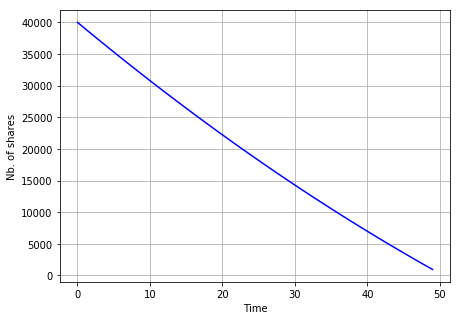

Risk aversion: -8e-07


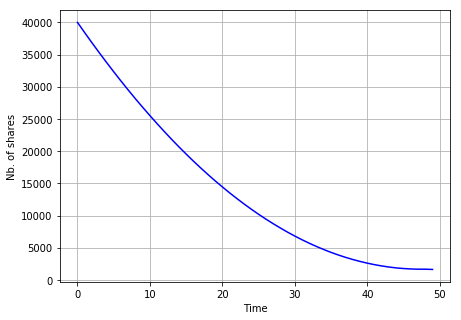

In [18]:
X = 40000
nb_T = 50
V = 4000000
v = np.ones((nb_T,1)) * V / nb_T

print('Risk aversion:', 5*10**(-7))
test = efficient_frontier_VWAP(X=X, risk=5*10**(-7), nb_T=nb_T,
                               v=v,
                               sigma=0.3,
                               s0=100,
                               tau=0.5,
                               gamma=2.5*10**(-7),
                               eta=2.5*10**(-6),
                               eps=0.0625)

print('Risk aversion:', -8*10**(-7))
test = efficient_frontier_VWAP(X=X, risk=-8*10**(-7), nb_T=nb_T,
                               v=v,
                               sigma=0.3,
                               s0=100,
                               tau=0.5,
                               gamma=2.5*10**(-7),
                               eta=2.5*10**(-6),
                               eps=0.0625)

### 3.2. Efficient frontier

We will test the following parameters:

- $X=40000$
- $N=50$
- $\tau=0.5$
- $\gamma=2.5 \times 10^{-7}$
- $\eta=2.5 \times 10^{-6}$
- $\varepsilon=0.0625$

for which we add for TWAP:

- $V=4000000$
- $V_i=80000, \,\,\, i=1,...,N$
- $S_0=100$

**Efficient frontier**:

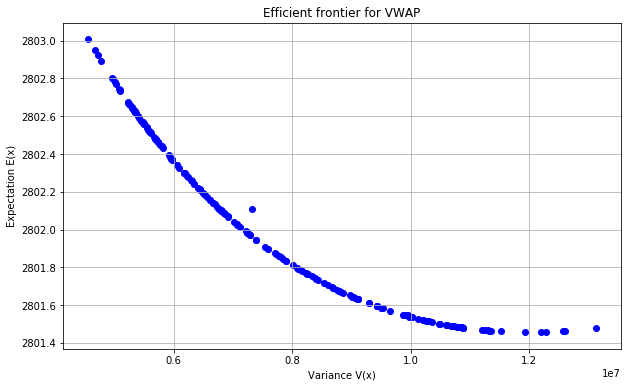

In [49]:
X = 40000
nb_T = 50
V = 4000000
v = np.ones((nb_T,1)) * V / nb_T

risks = np.linspace(0.1*10**(-7), 5.0*10**(-7), 200)
#risks = np.array([1, 2, 3, 4, 5])

x_VWAP = []
y_VWAP = []

for r in risks:
    temp = efficient_frontier_VWAP(X=X, risk=r, nb_T=nb_T,
                                   v=v,
                                   sigma=0.3,
                                   s0=100,
                                   tau=0.5,
                                   gamma=2.5*10**(-7),
                                   eta=2.5*10**(-6),
                                   eps=0.0625,
                                   plot='False')
    
    x_VWAP.append(temp[2])  # V(x)
    y_VWAP.append(temp[1])  # E(x)


# Plotting
# plt.figure(figsize=(10,6))
plt.figure(figsize=(10,6))

# Optimal strategies
plt.scatter(x_VWAP, y_VWAP, marker='o', color='blue')
#plt.scatter(x, y, marker='o', cmap='jet', c=risks)  # doesn't work for some reason
plt.grid(True)

plt.xlabel('Variance V(x)')
plt.ylabel('Expectation E(x)')
plt.title('Efficient frontier for VWAP')
# plt.colorbar(label='Risk aversion $\lambda$')
plt.savefig('efficient_frontier_VWAP.png')
plt.show()

**Optimal liquidation trajectories**:

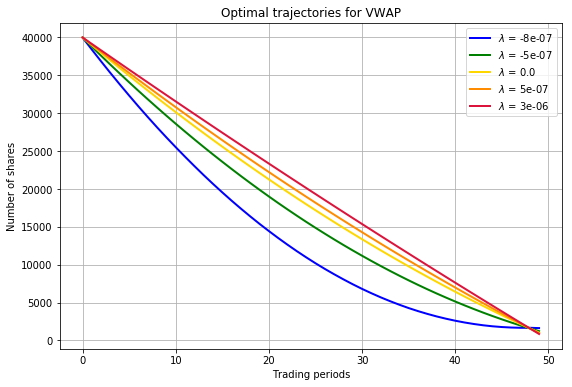

In [51]:
risks = [-8*10**(-7), -5*10**(-7), 0.0, 5*10**(-7), 30*10**(-7)]

N_opts = []

for r in risks:
    temp = efficient_frontier_VWAP(X=40000, risk=r, nb_T=50, v=v,
                                   tau=0.5, gamma=2.5*10**(-7), eta=2.5*10**(-6),
                                   eps=0.0625, plot='False')
    
    N_opts.append(temp[0])


# Plotting
plt.figure(figsize=(9,6))
plt.plot(N_opts[0], color='blue', lw=2.0, label='$\lambda$ = '+str(risks[0]))
plt.plot(N_opts[1], color='green', lw=2.0, label='$\lambda$ = '+str(risks[1]))
plt.plot(N_opts[2], color='gold', lw=2.0, label='$\lambda$ = '+str(risks[2]))
plt.plot(N_opts[3], color='darkorange', lw=2.0, label='$\lambda$ = '+str(risks[3]))
plt.plot(N_opts[4], color='crimson', lw=2.0, label='$\lambda$ = '+str(risks[4]))

plt.grid(True)
plt.title('Optimal trajectories for VWAP')
plt.xlabel('Trading periods')
plt.ylabel('Number of shares')
plt.legend(loc='best')
plt.savefig('liquidation_VWAP.png')
plt.show()

Our previous implementation assumes that the traded volume is constant, which explains the *flatness* of the liquidation trajectory. A limitation that can be addressed by using data of past historical traded volumes. We will be using Bloomberg data on the **traded volumes of Total SA** (ticker: FP FP Equity) on 16/03/2018, from 09:20:00 to 17:30:00 (50 datapoints, data frequency of 5 minutes).

In [52]:
v_TOTAL = np.loadtxt('vwap.txt')
print(v_TOTAL)
print(len(v_TOTAL))
print(int(np.sum(v_TOTAL)))

[    59211.    110950.     82526.     63937.     51954.     37506.
     22057.     46809.     40768.     68896.     74595.     75280.
     43975.     47404.    109237.   3165293.    155487.     44278.
     33911.     51182.     81941.     83262.     64853.     40836.
     72882.     68700.     60925.     32067.     45666.     37475.
     73632.     80731.    127068.     67304.    119088.     99309.
     98529.    102898.    174410.    180716.    144700.     84017.
    170334.    145090.    109145.     75203.    147899.    149098.
    203102.  12247952.]
50
19574088


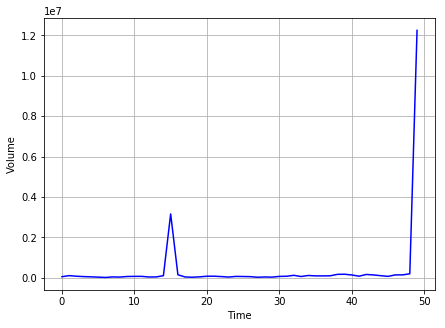

In [53]:
plt.figure(figsize=(7,5))
plt.plot(v_TOTAL, color='blue')
plt.xlabel('Time')
plt.ylabel('Volume')
plt.grid(True)
plt.show()

Risk aversion: 0.0005


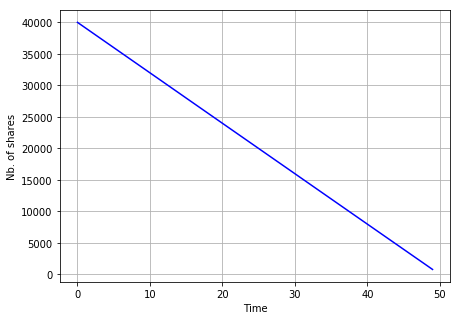

Risk aversion: -0.0008


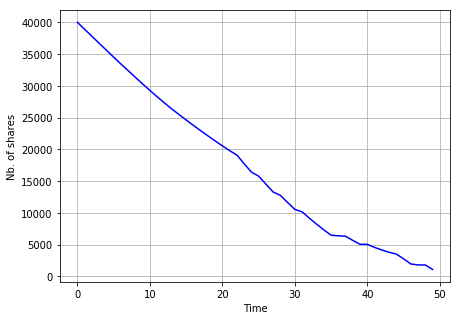

In [54]:
X = 40000
nb_T = 50

print('Risk aversion:', 5*10**(-4))
test = efficient_frontier_VWAP(X=X, risk=-2*10**(-7), nb_T=nb_T,
                               v=v_TOTAL,
                               sigma=0.3,
                               s0=100,
                               tau=0.5,
                               gamma=2.5*10**(-7),
                               eta=2.5*10**(-6),
                               eps=0.0625)

print('Risk aversion:', -8*10**(-4))
test = efficient_frontier_VWAP(X=X, risk=-8*10**(-7), nb_T=nb_T,
                               v=v_TOTAL,
                               sigma=0.3,
                               s0=100,
                               tau=0.5,
                               gamma=2.5*10**(-7),
                               eta=2.5*10**(-6),
                               eps=0.0625)

## 4. Efficient frontier for TWAP

### 4.1. Model

**Moments**

- *TWAP Algorithm*

$$ X_{TWAP} = X\frac{\sum_{i=1}^n \tau S_i}{\sum_{i=1}^n \tau} - \sum_{i=1}^n n_i \tilde S_i $$

- *Expectation*

$$ \mathbb{E}(X_{TWAP}) = \sum_{i=1}^n \left[\left(\frac{X}{T} \tau - n_i\right) \left (S_0 - \tau \sum_{j=1}^{i-1} g \left(\frac{n_j}{\tau}\right) \right) - \frac{X}{T} \tau^2 g \left(\frac{n_i}{\tau}\right) - n_i h\left(\frac{n_i}{\tau}\right)\right]$$

- *Variance*

$$ \mathbb{V}(X_{TWAP}) = \tau \sigma^2 \sum_{i=1}^n \left(\frac{X}{T} \sum_{j=i}^n \tau - x_i \right)^2 $$

In [55]:
def expectation_TWAP(n):
    """
    Returns the expected TWAP
    n, array - Trading trajectory
    X, integer - Number of shares to be liquidated
    s0, float - Initial spot price
    gamma, float - Parameter of the permanent market impact
    tau, float - Trading frequency
    eta, float - Parameter of the temporary market impact
    eps, float - Fixed cost of selling in the temporary market impact
    """
    N = len(n)
    T = tau*N
    e = 0
    for k in range(N):
        sumg=0
        for j in range(k):
            sumg+=g(n[j]/tau, gamma)
        e+=(X*tau/T - n[k])*(s0-sumg*tau) - X/T * tau**2*g(n[k]/tau, gamma) + n[k]*h(n[k]/tau, tau, eps, eta)
    return e

def variance_TWAP(n):
    """
    Returns the TWAP variance
    n, array - Trading trajectory
    X, integer - Number of shares to be liquidated
    s0, float - Initial spot price
    gamma, float - Parameter of the permanent market impact
    tau, float - Trading frequency
    eta, float - Parameter of the temporary market impact
    eps, float - Fixed cost of selling in the temporary market impact
    """
    var=0
    N = len(n)
    T = N * tau
    for k in range(N):
        tsum = 0
        for j in range(k,N):
            tsum+=tau
        x = X - np.sum(n[0:k])
        var+=(X/T * tsum-x)**2*sigma**2*tau
    return var

def objective_TWAP(n):
    return expectation_TWAP(n) + risk * variance_TWAP(n)

**Optimization**

$$ (n_1^*,...,n_N^*) = \min_{0<n_i<X} \mathbb{E}(X_{TWAP}) + \lambda \mathbb{V}(X_{TWAP}) $$

In [56]:
# Parameters
X = 40000.0                           # Number of shares to liquidate
nb_T = 10                             # Number of trading periods
risk = 2.5*10**(-7)                   # Risk aversion

tau = 0.5                             # Trading speed
gamma = 2.5*10**(-7)                  # Permanent market impact
eta = 2.5*10**(-6)                    # Temporary (variable) market impact
eps = 0.0625                          # Temporary (fixed) market impact
sigma = 0.3                           # Volatility
s0 = 100
n0 = np.ones((nb_T,1)) * X / nb_T

print(expectation_TWAP(n0))
print(variance_TWAP(n0))
print(objective_TWAP(n0))

[ 4060.]
0.0
[ 4060.]


In [57]:
# Parameters
X = 40000                          # Number of shares to liquidate
nb_T = 50                          # Number of trading periods
risk = 2.5*10**(-7)                # Risk aversion

tau = 0.5                          # Trading speed
gamma = 2.5*10**(-7)               # Permanent market impact
eta = 2.5*10**(-6)                 # Temporary (variable) market impact
eps = 0.0625                       # Temporary (fixed) market impact
sigma = 0.3                        # Volatility

# Optimization
x0 = np.zeros((nb_T, 1))           # Dimensionality of the optimization

bnds = tuple((0.0, X) for x in range(len(x0)))
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - X})

opt = minimize(objective_TWAP, x0, method='SLSQP', bounds=bnds, constraints=cons,
              options={'maxiter': 10000})
N_opt = np.array(opt.x)
print(opt)

# print('Liquidation trajectory:\n')
# print(np.matrix(opt.x.round(0)).T)

print('\nTotal number of shares:')
print(np.sum(opt.x))

print('\nExpectation E(x):')
print(expectation_TWAP(N_opt))

print('\nVariance V(x):')
print(variance_TWAP(N_opt))

     fun: 2803.8022693430394
     jac: array([-99.91604614, -99.91607666, -99.91607666, -99.91607666,
       -99.91610718, -99.9161377 , -99.9161377 , -99.91616821,
       -99.91619873, -99.91622925, -99.91629028, -99.9163208 ,
       -99.91635132, -99.9125061 , -99.91253662, -99.91650391,
       -99.91262817, -99.91268921, -99.91275024, -99.91281128,
       -99.91674805, -99.91680908, -99.91296387, -99.9130249 ,
       -99.91308594, -99.91314697, -99.91317749, -99.91323853,
       -99.91329956, -99.9133606 , -99.91342163, -99.91348267,
       -99.91351318, -99.91357422, -99.91558838, -99.9156189 ,
       -99.91567993, -99.91571045, -99.91577148, -99.915802  ,
       -99.91583252, -99.91586304, -99.91589355, -99.91494751,
       -99.91497803, -99.91595459, -99.91598511, -99.91549683,
       -99.91577148, -99.91577148])
 message: 'Optimization terminated successfully.'
    nfev: 707
     nit: 13
    njev: 13
  status: 0
 success: True
       x: array([ 998.82689797,  991.17966804,  982.

Liquidation history:


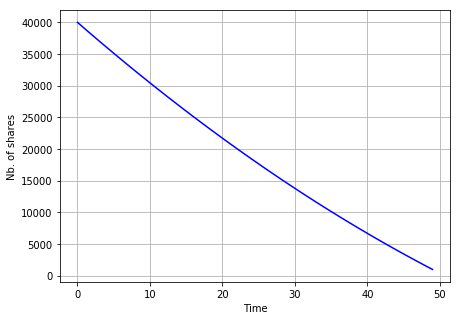

In [58]:
hist_opt = liquidation_history(N_opt, X)

print('Liquidation history:')

plt.figure(figsize=(7,5))
plt.plot(hist_opt, color='blue', lw=1.5)
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('Nb. of shares')
plt.show()

**Hyperparameter testing**:

In [59]:
def efficient_frontier_TWAP(X, risk, nb_T, sigma=0.3, s0=100, tau=1.0, gamma=1.0, eta=1.0, eps=1.0, plot='True'):
    
    def expectation_TWAP(n):
        N = len(n)
        T = tau*N
        e = 0
        for k in range(N):
            sumg=0
            for j in range(k):
                sumg+=g(n[j]/tau, gamma)
            e+=(X*tau/T - n[k])*(s0-sumg*tau) - X/T * tau**2*g(n[k]/tau, gamma) + n[k]*h(n[k]/tau, tau, eps, eta)
        return e

    def variance_TWAP(n):
        var=0
        N = len(n)
        T = N * tau
        for k in range(N):
            tsum = 0
            for j in range(k,N):
                tsum+=tau
            x = X - np.sum(n[0:k])
            var+=(X/T * tsum-x)**2*sigma**2*tau
        return var

    def objective_TWAP(n):
        return expectation_TWAP(n) + risk * variance_TWAP(n)
    
    def optimization_TWAP():
        x0 = np.zeros((nb_T, 1))
        bnds = tuple((0.0, X) for x in range(len(x0)))
        cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - X})
        opt = minimize(objective_TWAP, x0, method='SLSQP', bounds=bnds,
                       constraints=cons, options={'maxiter': 10000})
        N = np.array(opt.x)
        return N
    
    N_opt = optimization_TWAP()
    
    def liquidation_history(N_opt, X):
        hist = np.zeros((len(N_opt), 1))
        hist[0] = X
        for i in range(1, len(N_opt)):
            hist[i] = hist[i-1] - N_opt[i]
        return hist
    
    hist_opt = liquidation_history(N_opt,X)

    def plot_liquidation():
        plt.figure(figsize=(7,5))
        plt.plot(hist_opt, color='blue', lw=1.5)
        plt.grid(True)
        plt.xlabel('Time')
        plt.ylabel('Nb. of shares')
        plt.show()
    
    if plot=='True':
        plot_liquidation()
    
    res = hist_opt.round(0), expectation_TWAP(N_opt), variance_TWAP(N_opt)
    
    return res

Risk aversion: 5e-07


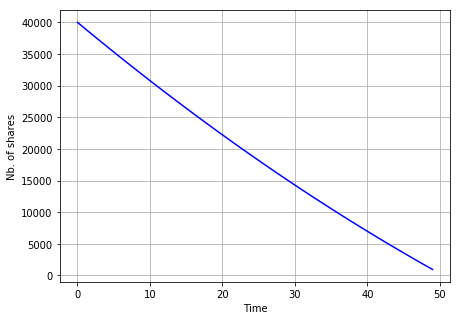

Risk aversion: -8e-07


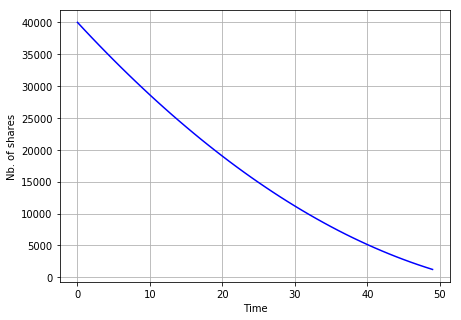

In [60]:
X = 40000
nb_T = 50

print('Risk aversion:', 5*10**(-7))
test = efficient_frontier_TWAP(X=X, risk=5*10**(-7), nb_T=nb_T,
                               sigma=0.3,
                               s0=100,
                               tau=0.5,
                               gamma=2.5*10**(-7),
                               eta=2.5*10**(-6),
                               eps=0.0625)

print('Risk aversion:', -8*10**(-7))
test = efficient_frontier_TWAP(X=X, risk=-5*10**(-7), nb_T=nb_T,
                               sigma=0.3,
                               s0=100,
                               tau=0.5,
                               gamma=2.5*10**(-7),
                               eta=2.5*10**(-6),
                               eps=0.0625)

### 4.2. Efficient frontier


We will test the following parameters:

- $X=40000$
- $N=50$
- $\tau=0.5$
- $\gamma=2.5 \times 10^{-7}$
- $\eta=2.5 \times 10^{-6}$
- $\varepsilon=0.0625$
- $S_0=100$

**Efficient frontier**:

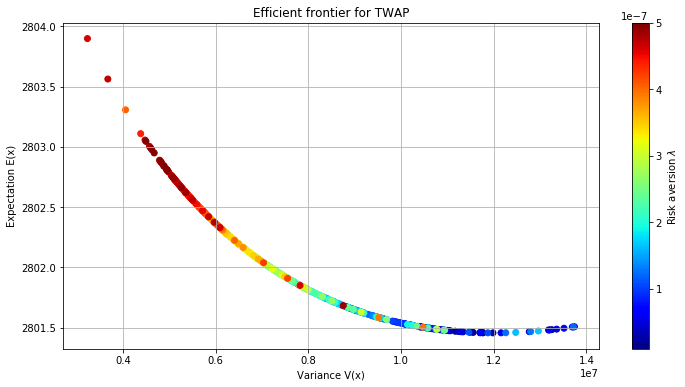

In [63]:
X = 40000
nb_T = 50

risks = np.linspace(0.1*10**(-7), 5.0*10**(-7), 500)
#risks = np.array([1, 2, 3, 4, 5])

x_TWAP = []
y_TWAP = []

for r in risks:
    temp = efficient_frontier_TWAP(X=X, risk=r, nb_T=nb_T,
                                   sigma=0.3,
                                   s0=100,
                                   tau=0.5,
                                   gamma=2.5*10**(-7),
                                   eta=2.5*10**(-6),
                                   eps=0.0625,
                                   plot='False')
    
    x_TWAP.append(temp[2])  # V(x)
    y_TWAP.append(temp[1])  # E(x)

# Plotting
#plt.figure(figsize=(10,6))
plt.figure(figsize=(12,6))

# Optimal strategies
#plt.scatter(x, y, marker='o', color='blue')
plt.scatter(x_TWAP, y_TWAP, marker='o', cmap='jet', c=risks)
plt.grid(True)

plt.xlabel('Variance V(x)')
plt.ylabel('Expectation E(x)')
plt.title('Efficient frontier for TWAP')
plt.colorbar(label='Risk aversion $\lambda$')
plt.savefig('efficient_frontier_TWAP.png')
plt.show()

**Optimal liquidation trajectories**:

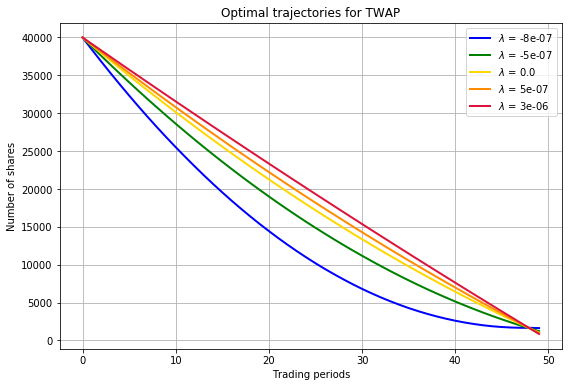

In [64]:
risks = [-8*10**(-7), -5*10**(-7), 0.0, 5*10**(-7), 30*10**(-7)]

N_opts = []

for r in risks:
    temp = efficient_frontier_VWAP(X=40000, risk=r, nb_T=50, v=v,
                                   tau=0.5, gamma=2.5*10**(-7), eta=2.5*10**(-6),
                                   eps=0.0625, plot='False')
    
    N_opts.append(temp[0])


# Plotting
plt.figure(figsize=(9,6))
plt.plot(N_opts[0], color='blue', lw=2.0, label='$\lambda$ = '+str(risks[0]))
plt.plot(N_opts[1], color='green', lw=2.0, label='$\lambda$ = '+str(risks[1]))
plt.plot(N_opts[2], color='gold', lw=2.0, label='$\lambda$ = '+str(risks[2]))
plt.plot(N_opts[3], color='darkorange', lw=2.0, label='$\lambda$ = '+str(risks[3]))
plt.plot(N_opts[4], color='crimson', lw=2.0, label='$\lambda$ = '+str(risks[4]))

plt.grid(True)
plt.title('Optimal trajectories for TWAP')
plt.xlabel('Trading periods')
plt.ylabel('Number of shares')
plt.legend(loc='best')
plt.savefig('liquidation_TWAP.png')
plt.show()